# Installation and Imports

In [9]:
# Check the GPU
!nvidia-smi

Thu Jul 16 03:06:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    347MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os.path

from keras import Model, optimizers
from keras.applications import xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from keras.models import load_model
import pandas as pd
import sys
import numpy as np

# Dataset

## Configuration Parameters

In [11]:
img_width = 197
img_height = 197

batch_size = 128

base_path = '/content/drive/My Drive/Colab_Notebooks/data/monkey/exports/'

train_path = base_path + 'train'
validation_path = base_path + 'valid'
test_path = base_path + 'test'

nb_classes = 10

## Preparing the dataset

In [12]:
# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
validation_samples = sum([len(files) for r, d, files in os.walk(validation_path)])
test_samples = sum([len(files) for r, d, files in os.walk(test_path)])

print("Number of samples in Training dataset:", training_samples)
print("Number of samples in Validation dataset:", validation_samples)
print("Number of samples in Test dataset:", test_samples)

Number of samples in Training dataset: 827
Number of samples in Validation dataset: 198
Number of samples in Test dataset: 200


## Data augmentation

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.2,
    rescale = 1.0 / 255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = False,
)

validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
)

Found 827 images belonging to 10 classes.
Found 198 images belonging to 10 classes.


# Model

## Importing the pre-trained model

In [14]:
# Import the Xception model to use as the base for our model
xception_base = xception.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_width, img_height, 3)
)

In [15]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 98, 98, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 98, 98, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 98, 98, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Transfer learning

In [16]:
# Adds new top to base model
def add_top(base):
    x = base.output

    # Global averaging pool layer
    x = GlobalAveragePooling2D()(x)

    # Regular densely connected layer
    x = Dense(512, activation='relu')(x)

    # Output layer
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs = base.input, outputs = predictions)

In [17]:
# Sets up model for transfer learning
def setup_model(model, base):
    # Freeze the un-trainable layers of the model base
    for layer in base.layers:
        layer.trainable = False

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'rmsprop',
        metrics = ['accuracy']
    )

In [18]:
# Fine tune the model
def fine_tune(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.9),
        metrics = ['accuracy']
    )

In [19]:
# appending our trainable layers to the end of the model
model = add_top(xception_base)

## Training

We are using a hybrid approach, at first we train with RMSprop/Adam until we get a better initial state for SGD optimizer, then we start the training again with SGD.

Training the layers we added while freezing all the original model layers.

In [20]:
# setup the model
setup_model(model, xception_base)

In [21]:
epochs = 20

# train the model
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_samples // batch_size,
    verbose = 1,
)

Epoch 1/20
6/6 [==============================] - 559s 93s/step - loss: 2.3766 - accuracy: 0.2847 - val_loss: 0.9018 - val_accuracy: 0.7734
Epoch 2/20
6/6 [==============================] - 110s 18s/step - loss: 1.1822 - accuracy: 0.6910 - val_loss: 1.6359 - val_accuracy: 0.6571
Epoch 3/20
6/6 [==============================] - 25s 4s/step - loss: 0.9742 - accuracy: 0.7357 - val_loss: 0.4349 - val_accuracy: 0.8594
Epoch 4/20
6/6 [==============================] - 18s 3s/step - loss: 0.6611 - accuracy: 0.8175 - val_loss: 0.8769 - val_accuracy: 0.8286
Epoch 5/20
6/6 [==============================] - 27s 4s/step - loss: 0.7415 - accuracy: 0.7839 - val_loss: 1.1298 - val_accuracy: 0.8672
Epoch 6/20
6/6 [==============================] - 23s 4s/step - loss: 0.5280 - accuracy: 0.8541 - val_loss: 0.9981 - val_accuracy: 0.7857
Epoch 7/20
6/6 [==============================] - 23s 4s/step - loss: 0.6116 - accuracy: 0.8169 - val_loss: 0.2750 - val_accuracy: 0.8984
Epoch 8/20
6/6 [==============

## Fine-tuning

Re-train the model again using the weights we got from the first training for our new added layers, and in the same time we will un-freeze the last two layers of the original model.

In [22]:
# fine tune the model to retrain our top layer plus blocks 13 and 14 of Xception
fine_tune(model, 19)

In [23]:
epochs_ft = 20

# train the model
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    epochs = epochs_ft,
    validation_data = validation_generator,
    validation_steps = validation_samples // batch_size,
    verbose = 1,
)

Epoch 1/20
6/6 [==============================] - 28s 5s/step - loss: 0.3984 - accuracy: 0.8784 - val_loss: 0.2988 - val_accuracy: 0.9297
Epoch 2/20
6/6 [==============================] - 23s 4s/step - loss: 0.3533 - accuracy: 0.8893 - val_loss: 0.3477 - val_accuracy: 0.9286
Epoch 3/20
6/6 [==============================] - 22s 4s/step - loss: 0.3317 - accuracy: 0.8952 - val_loss: 0.2631 - val_accuracy: 0.9609
Epoch 4/20
6/6 [==============================] - 23s 4s/step - loss: 0.3837 - accuracy: 0.8813 - val_loss: 0.3506 - val_accuracy: 0.8857
Epoch 5/20
6/6 [==============================] - 29s 5s/step - loss: 0.3444 - accuracy: 0.8919 - val_loss: 0.2366 - val_accuracy: 0.9453
Epoch 6/20
6/6 [==============================] - 20s 3s/step - loss: 0.4340 - accuracy: 0.8727 - val_loss: 0.3451 - val_accuracy: 0.9143
Epoch 7/20
6/6 [==============================] - 25s 4s/step - loss: 0.3044 - accuracy: 0.9084 - val_loss: 0.1588 - val_accuracy: 0.9453
Epoch 8/20
6/6 [==================

# Diagrams

## Model Diagrams

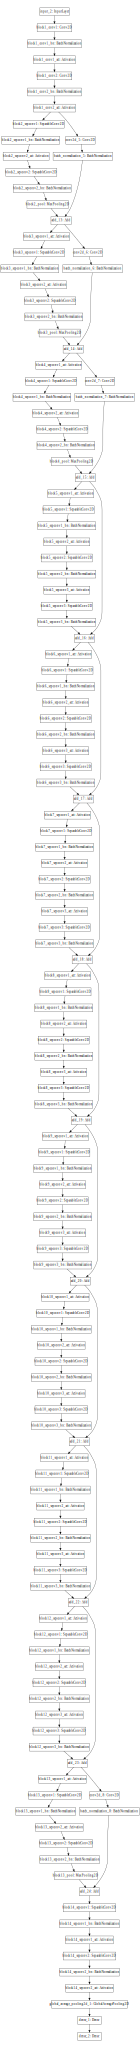

In [24]:
SVG(model_to_dot(model, show_shapes = False, show_layer_names=True, rankdir='HB', dpi = 72).create(prog='dot', format='svg'))

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 98, 98, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 98, 98, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 98, 98, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## Learning Curves


first half of the epochs is 'transfer learning', second half of the epochs is 'fine tuning'



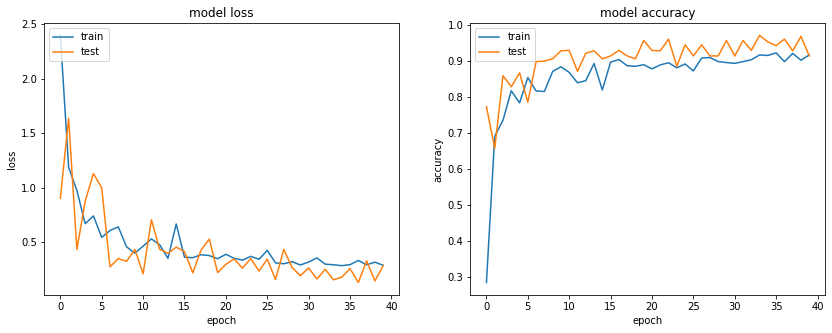

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

loss = history1.history["loss"] + history2.history["loss"]
val_loss = history1.history["val_loss"] + history2.history["val_loss"]
accuracy = history1.history["accuracy"] + history2.history["accuracy"]
val_accuracy = history1.history["val_accuracy"] + history2.history["val_accuracy"]

ax[0].plot(loss)
ax[0].plot(val_loss)
ax[0].set_title("model loss")
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epoch")
ax[0].legend(["train", "test"], loc="upper left")

ax[1].plot(accuracy)
ax[1].plot(val_accuracy)
ax[1].set_title("model accuracy")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epoch")
ax[1].legend(["train", "test"], loc="upper left")

print("\nfirst half of the epochs is 'transfer learning', second half of the epochs is 'fine tuning'\n")
plt.show()

About the spikes: SGD tinds to do these spikes because of the mini batches usage. For the first part, it is because we are doing a transfer learning.

If we had like 3000 epochs, our graph will smooth over and spikes won't be that noticable.

From the graph, we can see that more epochs will help in getting more accuracy, our model doesn't overfit, and there is no underfit.

# API

## Exporting

In [27]:
model.save('xception_model_ft.h5')
print("Model saved.")

Model saved.


## Importing

In [51]:
model = load_model('/content/drive/My Drive/Colab_Notebooks/Misc/xception_model_ft.h5')

## Testing

In [55]:
labels_dict= {'n0':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'n5':5, 'n6':6, 'n7':7, 'n8':8, 'n9':9}
def load_data(path_):
  df = []
  path = Path(path_)

  for folder in os.listdir(path):
    # Define the path to the images
    imgs_path = path / folder
 
    # Get the list of all the images stored in that directory
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    # Store each image path and corresponding label 
    for img_name in imgs:
      df.append((str(img_name), labels_dict[folder]))
 
  df = pd.DataFrame(df, columns=['image', 'label'], index=None)
  # shuffle the dataset 
  df = df.sample(frac=1.).reset_index(drop=True)
  
  return df

In [58]:
test = load_data(test_path)

monkey_labels = {
    0: "Mantled Howler",
    1: "Patas Monkey",
    2: "Bald Uakari",
    3: "Japanese Macaque",
    4: "Pygmy Marmoset",
    5: "White-headed Capuchin",
    6: "Silvery Marmoset",
    7: "Common Squirrel Monkey",
    8: "Black-headed Night Monkey",
    9: "Nilgiri Langur",
}

test.shape

(200, 2)

In [59]:
# Prints a prediction
def print_prediction(best_guess, prob):
    print("Species: " + monkey_labels[best_guess])
    print("Probability: {0:.2%}\n".format(prob))

# Loads an image and makes a prediction using the model
def predict_image(test_image_path):
    # Load image, downsize, scale and convert to array
    test_image = img_to_array(load_img(test_image_path, target_size=(img_width, img_height))) / 255.0

     # Expand array by 1 to match model
    test_image = np.expand_dims(test_image, axis=0)

     # Calculate category probabilities using model
    predictions = model.predict(test_image)[0]

     # Get label of highest probability prediction
    best_guess = 0
    highest_prob = 0.0
    for i in range(len(predictions)):
        if predictions[i] > highest_prob:
            best_guess = i
            highest_prob = predictions[i]

    return best_guess, highest_prob

In [60]:
#Calculate accurancy
count = 0
for i, t in test.iterrows():
  best_guess, highest_prob = predict_image(t['image'])
  if best_guess == t['label']:
    count = count + 1

print(count / test_samples)

0.95


In [61]:
#Preview Data 
for i, t in test.iterrows():
  print("True Label %s" % monkey_labels[t['label']]) 
  best_guess, highest_prob = predict_image(t['image'])
  print_prediction(best_guess, highest_prob)

True Label Mantled Howler
Species: Mantled Howler
Probability: 100.00%

True Label Black-headed Night Monkey
Species: Black-headed Night Monkey
Probability: 78.87%

True Label Bald Uakari
Species: Bald Uakari
Probability: 81.56%

True Label Bald Uakari
Species: Bald Uakari
Probability: 99.85%

True Label White-headed Capuchin
Species: White-headed Capuchin
Probability: 100.00%

True Label Mantled Howler
Species: Mantled Howler
Probability: 99.94%

True Label Japanese Macaque
Species: Japanese Macaque
Probability: 100.00%

True Label Nilgiri Langur
Species: Nilgiri Langur
Probability: 100.00%

True Label Common Squirrel Monkey
Species: Common Squirrel Monkey
Probability: 100.00%

True Label Mantled Howler
Species: Mantled Howler
Probability: 100.00%

True Label Common Squirrel Monkey
Species: Common Squirrel Monkey
Probability: 100.00%

True Label Nilgiri Langur
Species: Nilgiri Langur
Probability: 100.00%

True Label Mantled Howler
Species: Mantled Howler
Probability: 100.00%

True Lab

# References
* https://colab.research.google.com/github/nipunbatra/blog/blob/master/_notebooks/2017-12-29-neural-collaborative-filtering.ipynb#scrollTo=t23DgPbMQFng
* https://www.kaggle.com/slothkong/10-monkey-species?select=monkey_labels.txt
* https://keras.io/api/applications/
* https://www.kaggle.com/voandy/transfer-learning-fine-tuning-xception-98-7-acc
* https://github.com/zaid478/Transfer-Learning-from-Xception-Model-in-Keras-/blob/master/transfer_learn.py
* https://medium.com/@vigneshgig/xception-neural-network-transfer-learning-and-data-processing-using-ai-c3e7a4ea7bf2
* https://www.kaggle.com/abnera/transfer-learning-keras-xception-cnn
* https://arxiv.org/abs/1610.02357
* https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568
* https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
* https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
* https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
* https://keras.io/guides/transfer_learning/
* https://stats.stackexchange.com/questions/303857/explanation-of-spikes-in-training-loss-vs-iterations-with-adam-optimizer

